# DPSI case study

### Notebook helper function for pretty output

In [1]:
from IPython.display import Markdown, display
from ipywidgets import interact
from tabulate import tabulate


def print_md(markdown_printable):
    """Pretty render Markdown."""
    display(Markdown(str(markdown_printable)))


def print_yaml_file(file_path):
    """Pretty render yaml file."""
    with open(file_path) as f:
        print_md(f"```yaml\n{f.read()}\n```")

### Plotting functions ([`pyglotaran_extras`](https://github.com/s-weigand/pyglotaran-extras/commit/20da3593105fb839f86e668dc12dc9ca87c3b9ce) + `matplotlib`)

In [2]:
import matplotlib.pyplot as plt
from pyglotaran_extras.plotting.plot_overview import plot_overview
from pyglotaran_extras.plotting.plot_svd import plot_svd
from pyglotaran_extras.plotting.style import PlotStyle

plot_style = PlotStyle()
plt.rc("axes", prop_cycle=plot_style.cycler)
plt.rcParams["figure.figsize"] = (21, 14)

### Analysis functions

In [3]:
from glotaran.analysis.optimize import optimize
from glotaran.io import load_dataset, load_model, load_parameters
from glotaran.project.scheme import Scheme

### Read data

In [4]:
dataset1 = load_dataset("data/RT400_590excDPSIjul30tr24KtargetPB10a.ascii")
dataset2 = load_dataset("data/RT400_590excDPSIjul30tr24KtargetPB10b.ascii")
dataset3 = load_dataset("data/RT400_590excDPSIjul30tr24KtargetPB10c.ascii")
dataset4 = load_dataset("data/RT400_590excDPSIjul30tr24KtargetPB10d.ascii")
dataset5 = load_dataset("data/RT400_590excDPSIjul30tr24KtargetPB10e.ascii")
dataset6 = load_dataset("data/RT400_590excDPSIjul30tr24KtargetPB10f.ascii")

four_datasets = {"dataset1": dataset1,"dataset2": dataset2, "dataset3": dataset3,
            "dataset4": dataset4}
six_datasets = {**four_datasets, "dataset5": dataset5, "dataset6": dataset6}

def plot_datasets(dataset_name):
    """Plot helper function to use with widgets"""
    dataset = six_datasets[dataset_name]
    if len(dataset.data.time) > 1:
        dataset.data.plot(x="time", center=False)
    else:
        dataset.data.plot()
    
interact(plot_datasets, dataset_name=list(six_datasets.keys()))

interactive(children=(Dropdown(description='dataset_name', options=('dataset1', 'dataset2', 'dataset3', 'datas…

<function __main__.plot_datasets(dataset_name)>

## Sequential Model

### Load model and parameters

In [5]:
sequential_model = load_model("models/model_DPSI_sequential_irf.yml")
sequential_parameters = load_parameters("models/parameters_DPSI_sequential_irf.yml")
print_md(sequential_model.validate(parameters=sequential_parameters))

Your model is valid.

In [6]:
print_md(sequential_model)

# Model

_Type_: kinetic-spectrum

## Initial Concentration

* **input400**:
  * *Label*: input400
  * *Compartments*: ['s1', 's2', 's3', 's4']
  * *Parameters*: [inputs.s2, inputs.s1, inputs.s1, inputs.s1]
  * *Exclude From Normalize*: []
* **input590**:
  * *Label*: input590
  * *Compartments*: ['t1', 't2', 't3', 't4']
  * *Parameters*: [inputs.s2, inputs.s1, inputs.s1, inputs.s1]
  * *Exclude From Normalize*: []

## K Matrix

* **km1**:
  * *Label*: km1
  * *Matrix*: 
    * *('s2', 's1')*: rates.k1
    * *('s3', 's2')*: rates.k2
    * *('s4', 's3')*: rates.k3
    * *('s4', 's4')*: rates.k4
  
* **km2**:
  * *Label*: km2
  * *Matrix*: 
    * *('t2', 't1')*: rates2.k1
    * *('t3', 't2')*: rates2.k2
    * *('t4', 't3')*: rates2.k3
    * *('t4', 't4')*: rates2.k4
  

## Irf

* **irf1** (spectral-multi-gaussian):
  * *Label*: irf1
  * *Type*: spectral-multi-gaussian
  * *Center*: [irf.center1]
  * *Width*: [irf.width1, irf.width2]
  * *Scale*: [irf.scale1, irf.scale2]
  * *Normalize*: True
  * *Backsweep*: True
  * *Backsweep Period*: irf.common_backsweep
  * *Dispersion Center*: irf.common_dispcenter
  * *Center Dispersion*: [irf.data1_disp1, irf.data1_disp2]
  * *Width Dispersion*: []
  * *Model Dispersion With Wavenumber*: False
* **irf2** (spectral-multi-gaussian):
  * *Label*: irf2
  * *Type*: spectral-multi-gaussian
  * *Center*: [irf.center2]
  * *Width*: [irf.width3, irf.width4]
  * *Scale*: [irf.scale1, irf.scale3]
  * *Normalize*: True
  * *Backsweep*: True
  * *Backsweep Period*: irf.common_backsweep
  * *Dispersion Center*: irf.common_dispcenter
  * *Center Dispersion*: [irf.data1_disp1, irf.data1_disp2]
  * *Width Dispersion*: []
  * *Model Dispersion With Wavenumber*: False
* **irf3** (spectral-multi-gaussian):
  * *Label*: irf3
  * *Type*: spectral-multi-gaussian
  * *Center*: [irf.center3]
  * *Width*: [irf.width5, irf.width6]
  * *Scale*: [irf.scale1, irf.scale4]
  * *Normalize*: True
  * *Backsweep*: True
  * *Backsweep Period*: irf.common_backsweep
  * *Dispersion Center*: irf.common_dispcenter
  * *Center Dispersion*: [irf.data1_disp3, irf.data1_disp4]
  * *Width Dispersion*: []
  * *Model Dispersion With Wavenumber*: False
* **irf4** (spectral-multi-gaussian):
  * *Label*: irf4
  * *Type*: spectral-multi-gaussian
  * *Center*: [irf.center4]
  * *Width*: [irf.width7, irf.width8]
  * *Scale*: [irf.scale1, irf.scale5]
  * *Normalize*: True
  * *Backsweep*: True
  * *Backsweep Period*: irf.common_backsweep
  * *Dispersion Center*: irf.common_dispcenter
  * *Center Dispersion*: [irf.data1_disp3, irf.data1_disp4]
  * *Width Dispersion*: []
  * *Model Dispersion With Wavenumber*: False

## Dataset

* **dataset1**:
  * *Label*: dataset1
  * *Megacomplex*: ['complex1']
  * *Scale*: scale.1
  * *Initial Concentration*: input400
  * *Irf*: irf1
* **dataset2**:
  * *Label*: dataset2
  * *Megacomplex*: ['complex1']
  * *Scale*: scale.2
  * *Initial Concentration*: input400
  * *Irf*: irf2
* **dataset3**:
  * *Label*: dataset3
  * *Megacomplex*: ['complex2']
  * *Scale*: scale.3
  * *Initial Concentration*: input590
  * *Irf*: irf3
* **dataset4**:
  * *Label*: dataset4
  * *Megacomplex*: ['complex2']
  * *Scale*: scale.4
  * *Initial Concentration*: input590
  * *Irf*: irf4

## Megacomplex

* **complex1** (None):
  * *Label*: complex1
  * *K Matrix*: ['km1']
* **complex2** (None):
  * *Label*: complex2
  * *K Matrix*: ['km2']



### Create scheme and optimize it

In [30]:
sequential_scheme = Scheme(sequential_model, sequential_parameters, data=four_datasets, 
                           group_tolerance=1.9, non_negative_least_squares=True, 
                           maximum_number_function_evaluations=2)
sequential_result = optimize(sequential_scheme)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.9238e+07                                    3.53e+10    
       1              2         1.2521e+07      3.67e+07       3.61e-01       7.57e+08    
The maximum number of function evaluations is exceeded.
Function evaluations 2, initial cost 4.9238e+07, final cost 1.2521e+07, first-order optimality 7.57e+08.


In [8]:
root_mean_square_errors = []
for dataset_name in four_datasets.keys():
    root_mean_square_errors.append((dataset_name,sequential_result.data[dataset_name].root_mean_square_error))
print_md(tabulate(root_mean_square_errors, headers=("dataset", "RMS-Error"), tablefmt="github"))

| dataset   |   RMS-Error |
|-----------|-------------|
| dataset1  |     4.94583 |
| dataset2  |     3.18757 |
| dataset3  |    13.283   |
| dataset4  |    10.7395  |

### Result plots

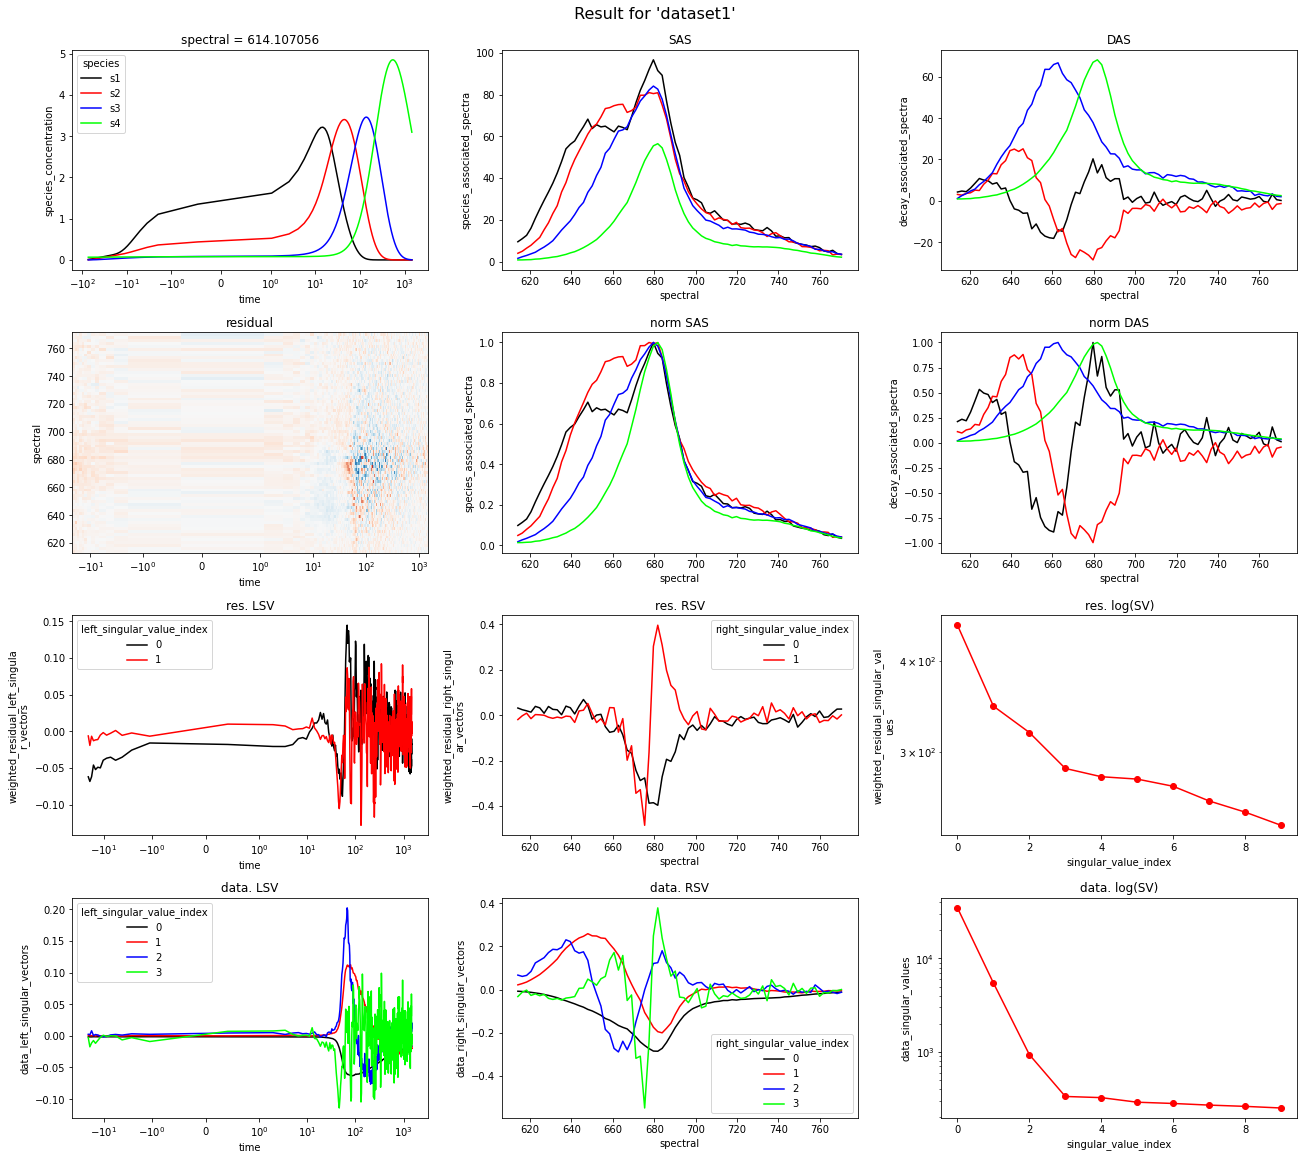

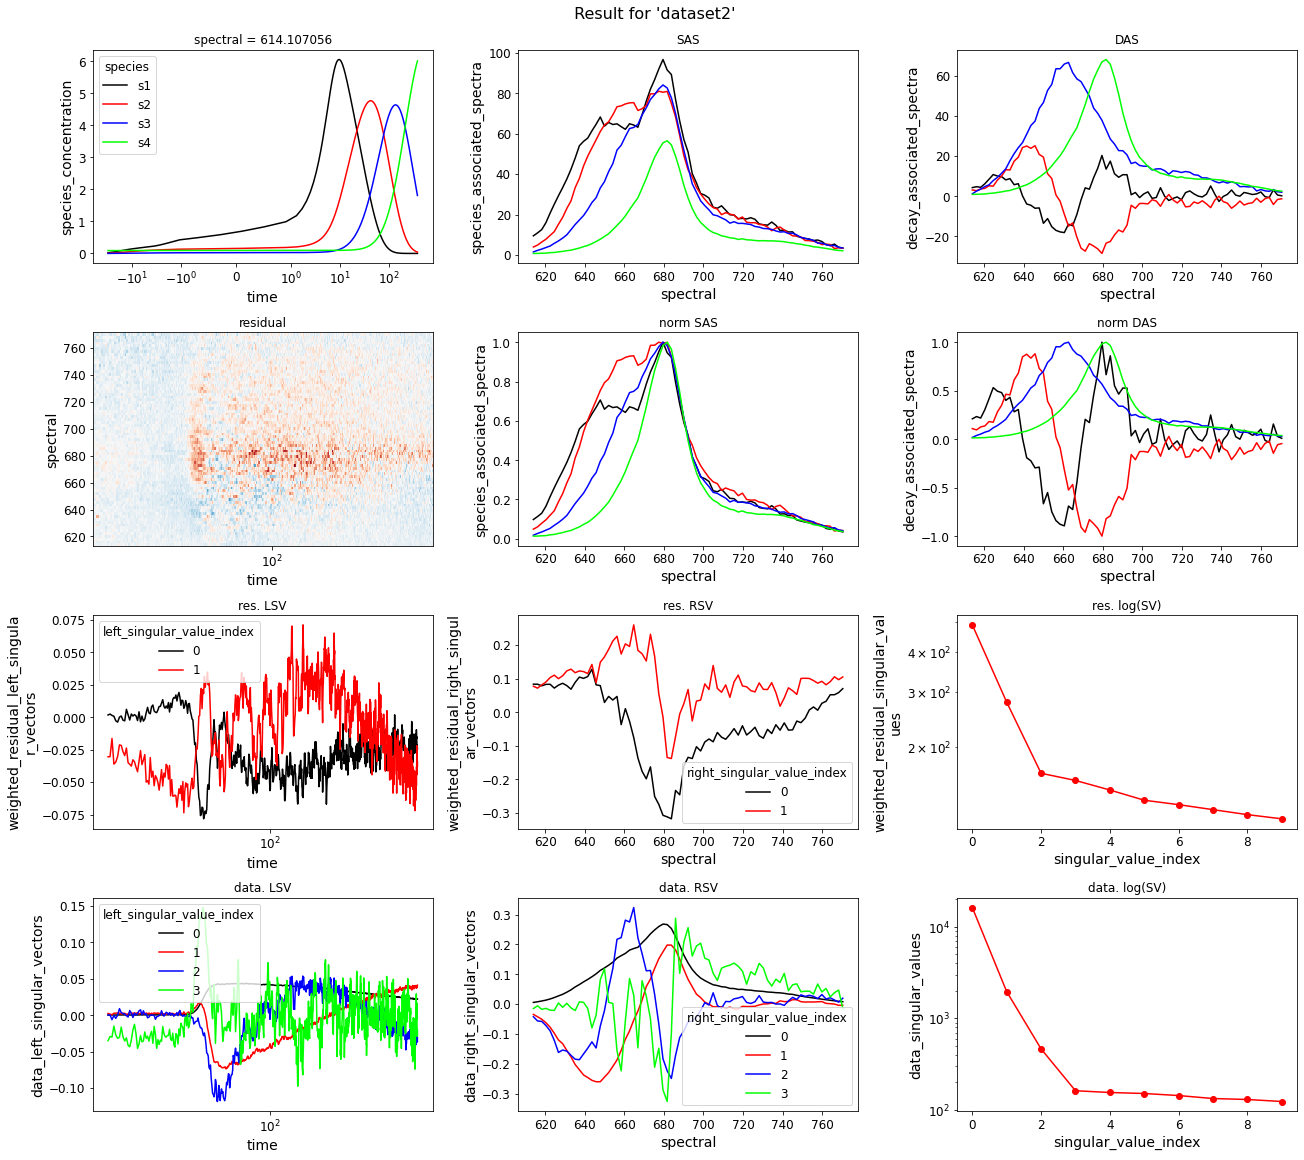

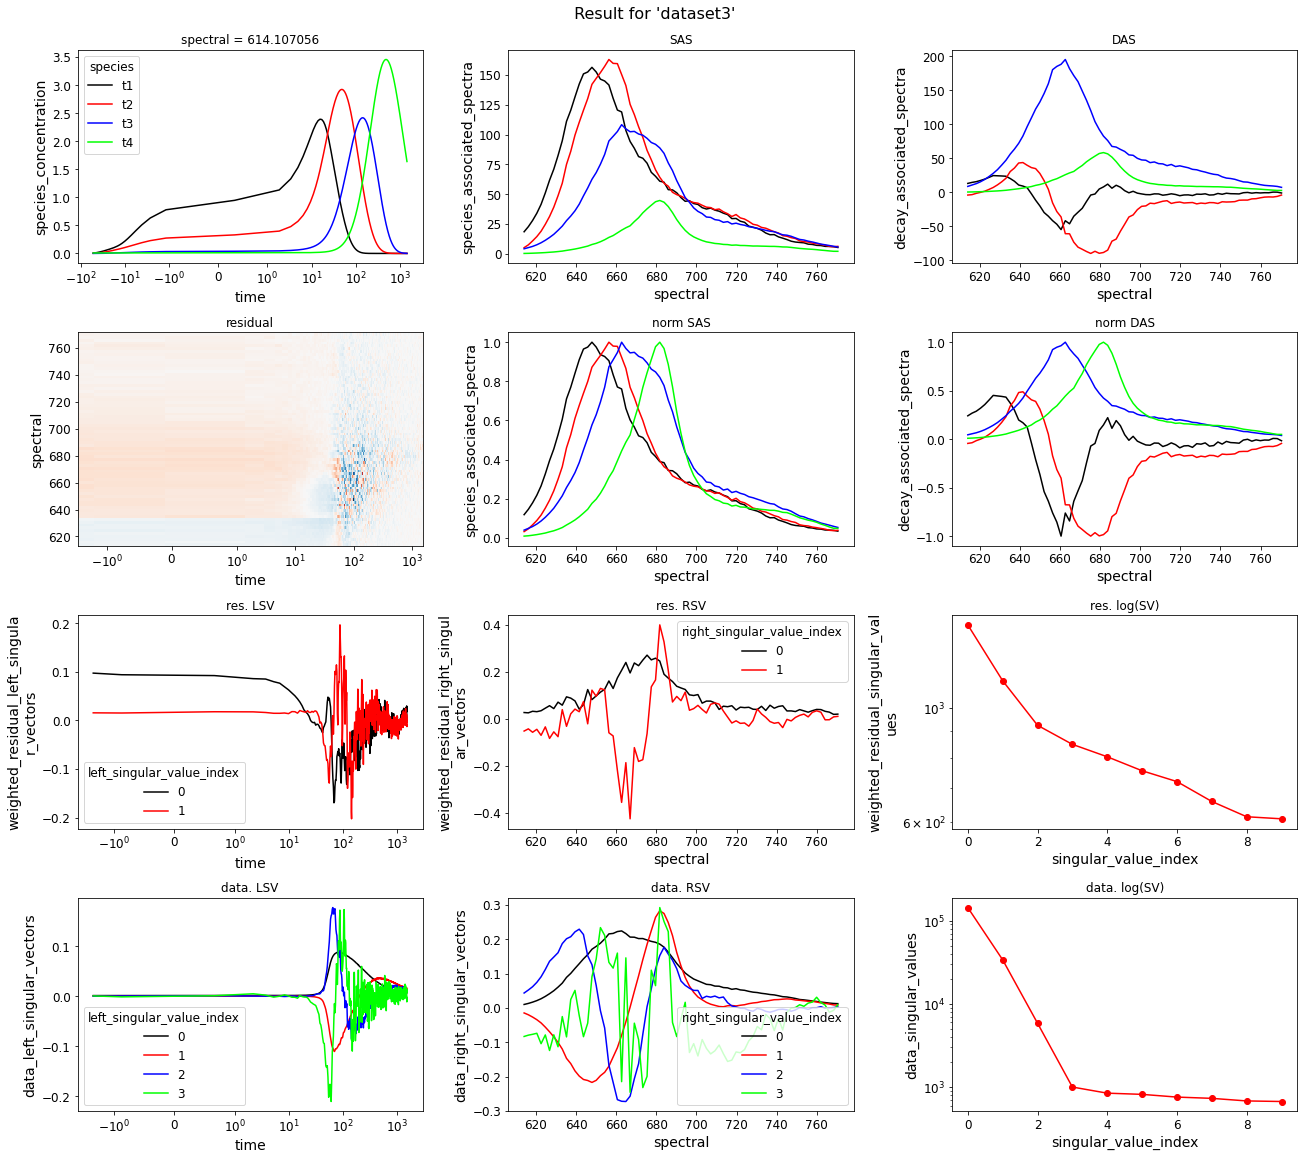

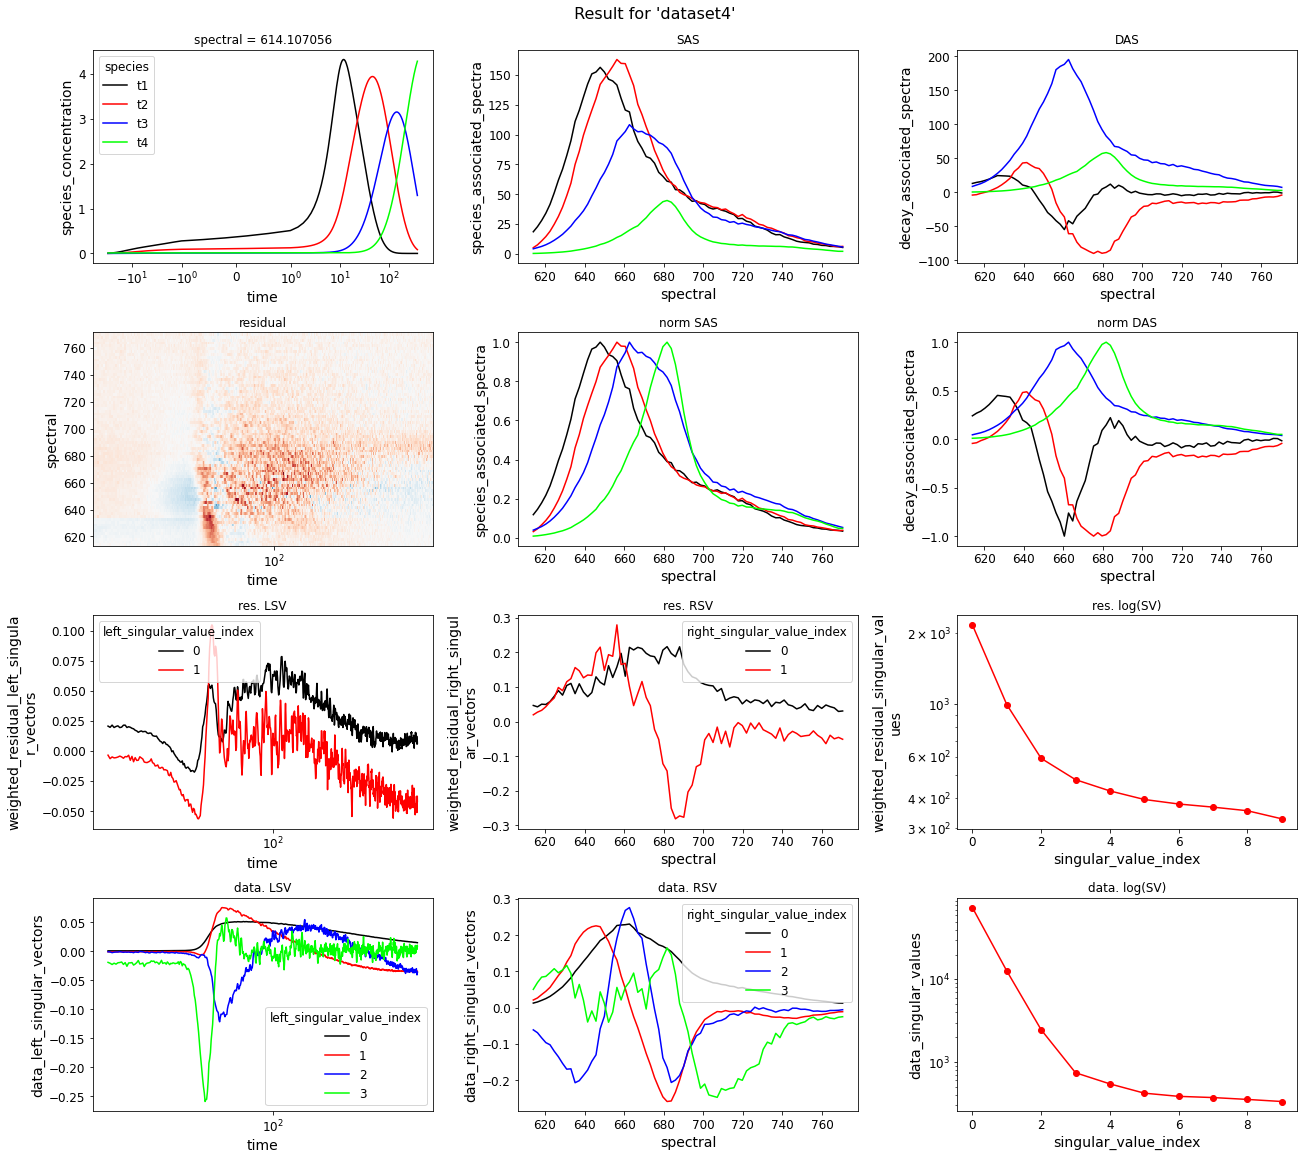

In [9]:
for dataset_name in four_datasets.keys():
    fig = plot_overview(sequential_result.data[dataset_name]);
    fig.suptitle(f'Result for {dataset_name!r}', fontsize=16)

In [10]:
print_md(sequential_result.optimized_parameters)

  * __inputs__:

    | _Label_   |   _Value_ |   _StdErr_ |   _Min_ |   _Max_ | _Vary_   | _Non-Negative_   | _Expr_   |
    |-----------|-----------|------------|---------|---------|----------|------------------|----------|
    | s1        |         0 |          0 |    -inf |     inf | False    | False            | None     |
    | s2        |         1 |          0 |    -inf |     inf | False    | False            | None     |

  * __irf__:

    | _Label_           |      _Value_ |    _StdErr_ |   _Min_ |   _Max_ | _Vary_   | _Non-Negative_   | _Expr_   |
    |-------------------|--------------|-------------|---------|---------|----------|------------------|----------|
    | center1           |    51.2006   | 0           |    -inf |     inf | False    | False            | None     |
    | center2           |    50.7999   | 0           |    -inf |     inf | False    | False            | None     |
    | center3           |    50.8097   | 0           |    -inf |     inf | False    | False            | None     |
    | center4           |    50.6241   | 0           |    -inf |     inf | False    | False            | None     |
    | width1            |     8.1106   | 0           |    -inf |     inf | False    | False            | None     |
    | width2            |    37.0027   | 0           |    -inf |     inf | False    | False            | None     |
    | width3            |     2.9626   | 0           |    -inf |     inf | False    | False            | None     |
    | width4            |    18.3664   | 0           |    -inf |     inf | False    | False            | None     |
    | width5            |     8.2726   | 0           |    -inf |     inf | False    | False            | None     |
    | width6            |    25.1026   | 0           |    -inf |     inf | False    | False            | None     |
    | width7            |     3.38693  | 0           |    -inf |     inf | False    | False            | None     |
    | width8            |    14.6401   | 0           |    -inf |     inf | False    | False            | None     |
    | scale1            |     1        | 0           |    -inf |     inf | False    | False            | None     |
    | scale2            |     0.183932 | 0.000384904 |    -inf |     inf | True     | False            | None     |
    | scale3            |     0.13267  | 0.000716372 |    -inf |     inf | True     | False            | None     |
    | scale4            |     0.251294 | 0.000105041 |    -inf |     inf | True     | False            | None     |
    | scale5            |     0.183123 | 0.000180986 |    -inf |     inf | True     | False            | None     |
    | common_dispcenter |   700        | 0           |    -inf |     inf | False    | False            | None     |
    | data1_disp1       |    -1.64111  | 0           |    -inf |     inf | False    | False            | None     |
    | data1_disp2       |     4.38865  | 0           |    -inf |     inf | False    | False            | None     |
    | data1_disp3       |    -2.19848  | 0           |    -inf |     inf | False    | False            | None     |
    | data1_disp4       |     6.1781   | 0           |    -inf |     inf | False    | False            | None     |
    | common_backsweep  | 13800        | 0           |    -inf |     inf | False    | False            | None     |

  * __rates__:

    | _Label_   |     _Value_ |    _StdErr_ |   _Min_ |   _Max_ | _Vary_   | _Non-Negative_   | _Expr_   |
    |-----------|-------------|-------------|---------|---------|----------|------------------|----------|
    | k1        | 0.0443753   | 0.000244205 |    -inf |     inf | True     | False            | None     |
    | k2        | 0.0155426   | 5.327e-05   |    -inf |     inf | True     | False            | None     |
    | k3        | 0.00567269  | 5.09484e-06 |    -inf |     inf | True     | False            | None     |
    | k4        | 0.000685806 | 2.61558e-07 |    -inf |     inf | True     | False            | None     |

  * __rates2__:

    | _Label_   |     _Value_ |    _StdErr_ |   _Min_ |   _Max_ | _Vary_   | _Non-Negative_   | _Expr_   |
    |-----------|-------------|-------------|---------|---------|----------|------------------|----------|
    | k1        | 0.0473777   | 3.33403e-05 |    -inf |     inf | True     | False            | None     |
    | k2        | 0.0125808   | 5.28736e-06 |    -inf |     inf | True     | False            | None     |
    | k3        | 0.0062888   | 9.33754e-07 |    -inf |     inf | True     | False            | None     |
    | k4        | 0.000966867 | 1.27058e-07 |    -inf |     inf | True     | False            | None     |

  * __rel__:

    | _Label_   |   _Value_ |   _StdErr_ |   _Min_ |   _Max_ | _Vary_   | _Non-Negative_   | _Expr_   |
    |-----------|-----------|------------|---------|---------|----------|------------------|----------|
    | r1        |         1 |          0 |    -inf |     inf | False    | False            | None     |

  * __scale__:

    |   _Label_ |   _Value_ |    _StdErr_ |   _Min_ |   _Max_ | _Vary_   | _Non-Negative_   | _Expr_   |
    |-----------|-----------|-------------|---------|---------|----------|------------------|----------|
    |         1 |  1        | 0           |    -inf |     inf | False    | False            | None     |
    |         2 |  0.224629 | 0.00107985  |    -inf |     inf | True     | False            | None     |
    |         3 |  4.5534   | 0           |    -inf |     inf | False    | False            | None     |
    |         4 |  0.962195 | 0.000823381 |    -inf |     inf | True     | False            | None     |

  * __scalem__:

    |   _Label_ |   _Value_ |   _StdErr_ |   _Min_ |   _Max_ | _Vary_   | _Non-Negative_   | _Expr_   |
    |-----------|-----------|------------|---------|---------|----------|------------------|----------|
    |         1 |         1 |          0 |    -inf |     inf | False    | False            | None     |



## Guidance Model

### Load model and parameters

In [40]:
guidance_model = load_model("models/model_DPSI_guidance_no_area_irf.yml")
guidance_parameters = load_parameters("models/parameters_DPSI_guidance_no_area_irf.yml")
print_md(guidance_model.validate(parameters=guidance_parameters))

Your model is valid.

In [ ]:
print_md(guidance_model)

### Create scheme and optimize it

In [41]:
guidance_scheme = Scheme(guidance_model, guidance_parameters, data=six_datasets, 
                           group_tolerance=1.9, non_negative_least_squares=True, 
                           maximum_number_function_evaluations=2)
guidance_result = optimize(guidance_scheme)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.8764e+07                                    1.34e+09    
       1              2         8.8764e+07      0.00e+00       0.00e+00       1.34e+09    
The maximum number of function evaluations is exceeded.
Function evaluations 2, initial cost 8.8764e+07, final cost 8.8764e+07, first-order optimality 1.34e+09.


In [42]:
root_mean_square_errors = []
for dataset_name in six_datasets.keys():
    root_mean_square_errors.append((dataset_name, guidance_result.data[dataset_name].root_mean_square_error))
print_md(tabulate(root_mean_square_errors, headers=("dataset", "RMS-Error"), tablefmt="github"))

| dataset   |   RMS-Error |
|-----------|-------------|
| dataset1  |    10.2214  |
| dataset2  |    46.2697  |
| dataset3  |    12.7631  |
| dataset4  |     7.83149 |
| dataset5  |   257.745   |
| dataset6  |   167.118   |

### Result plots

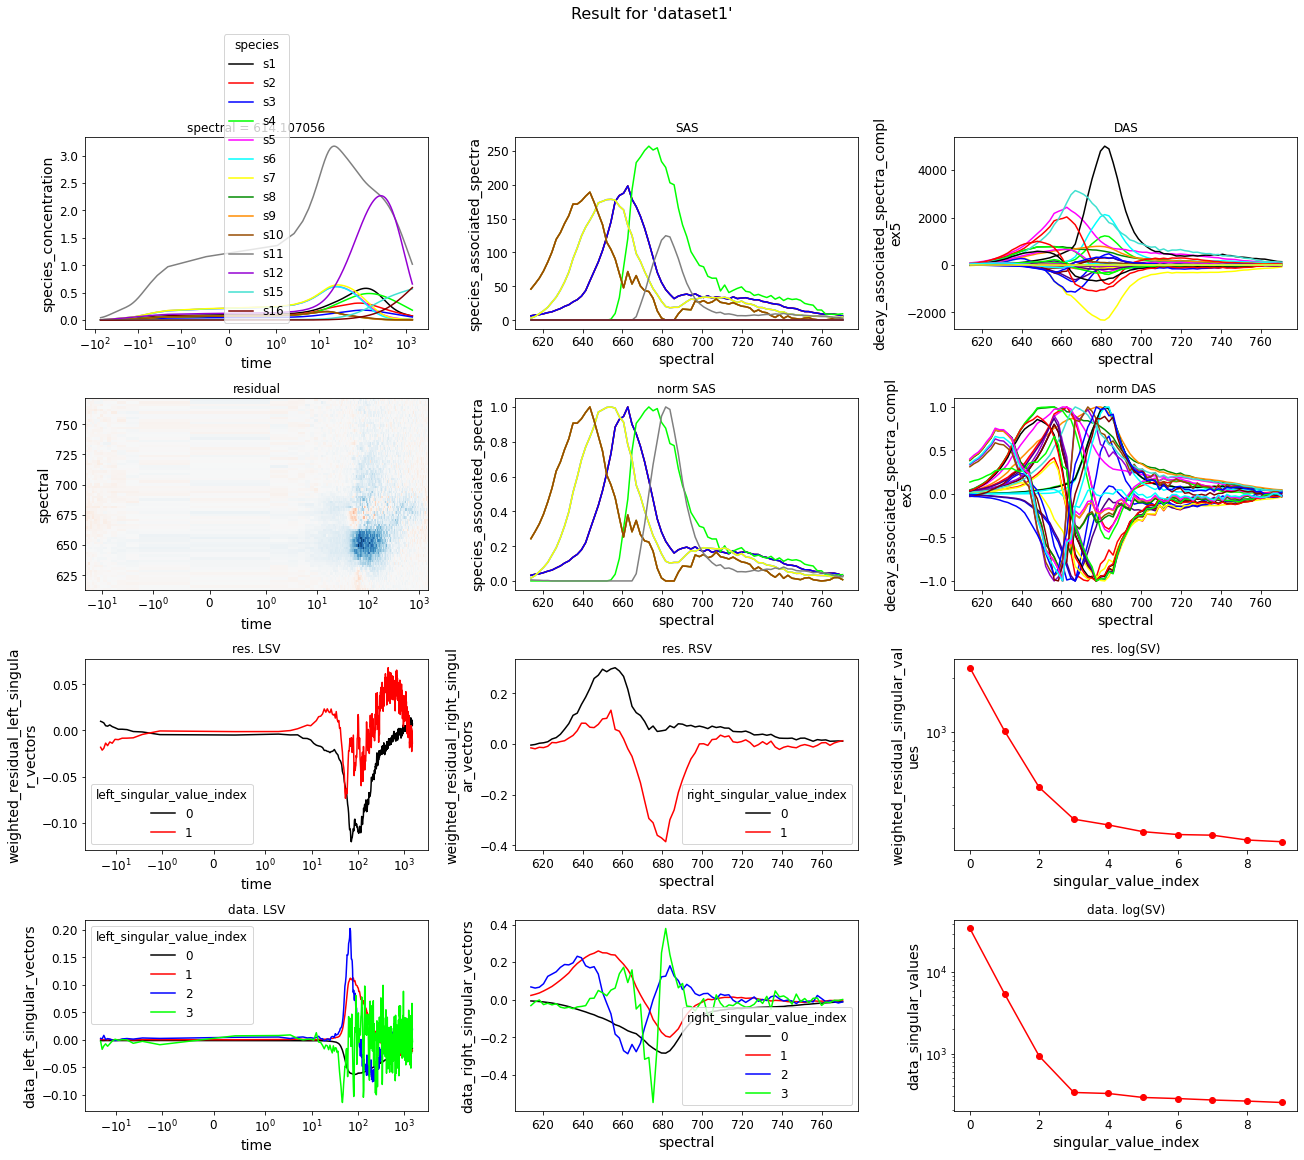

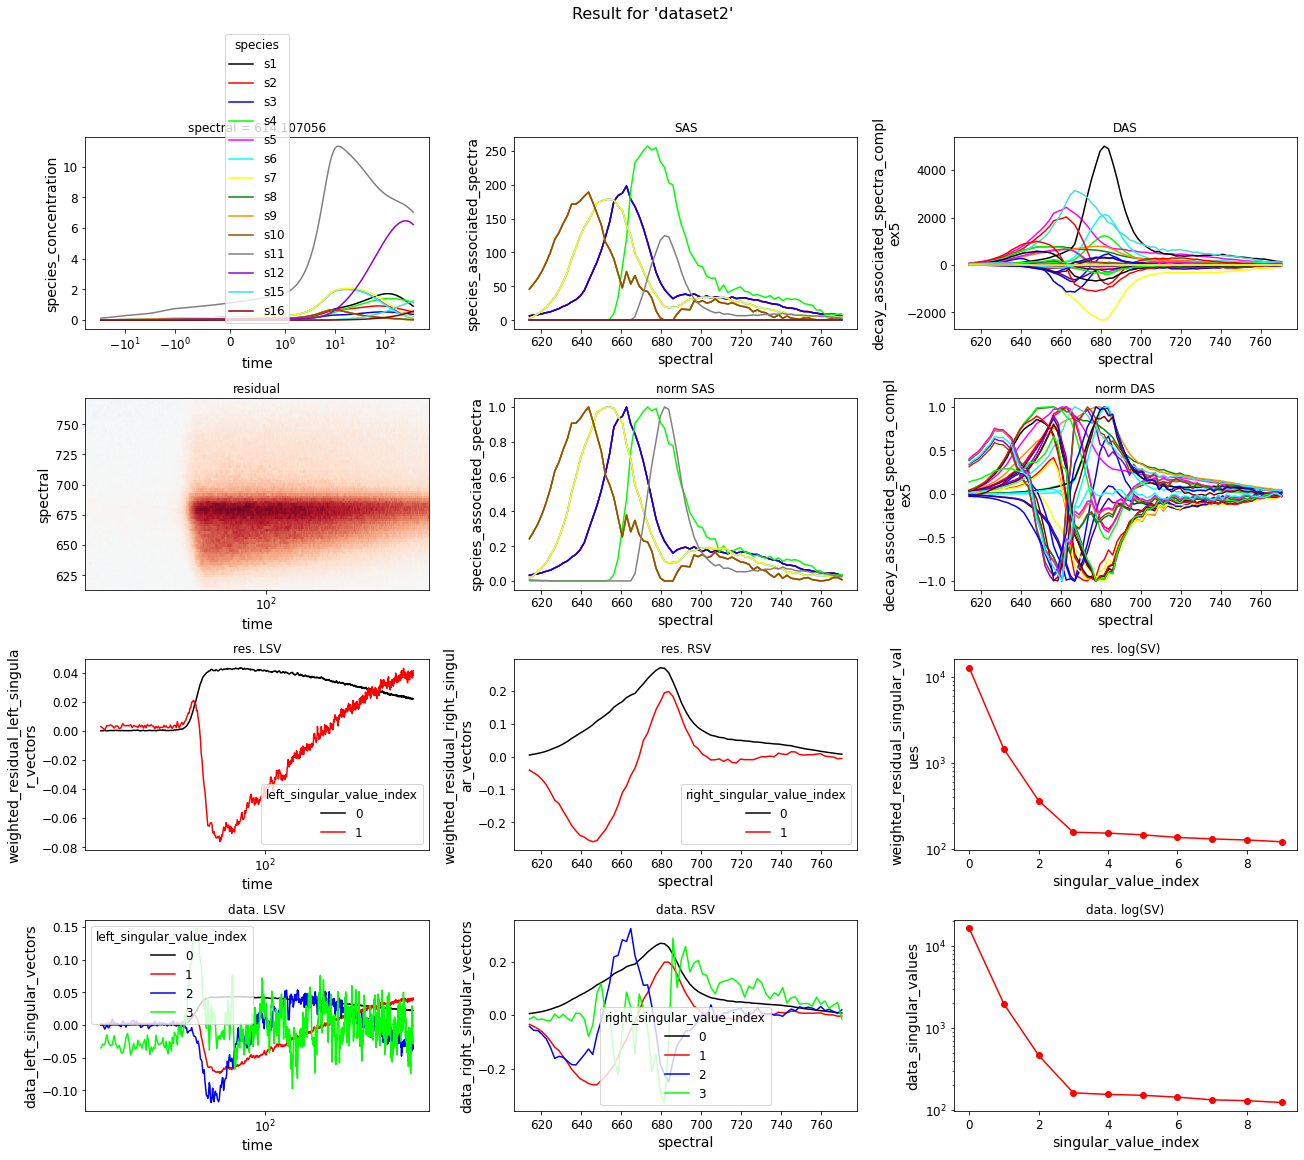

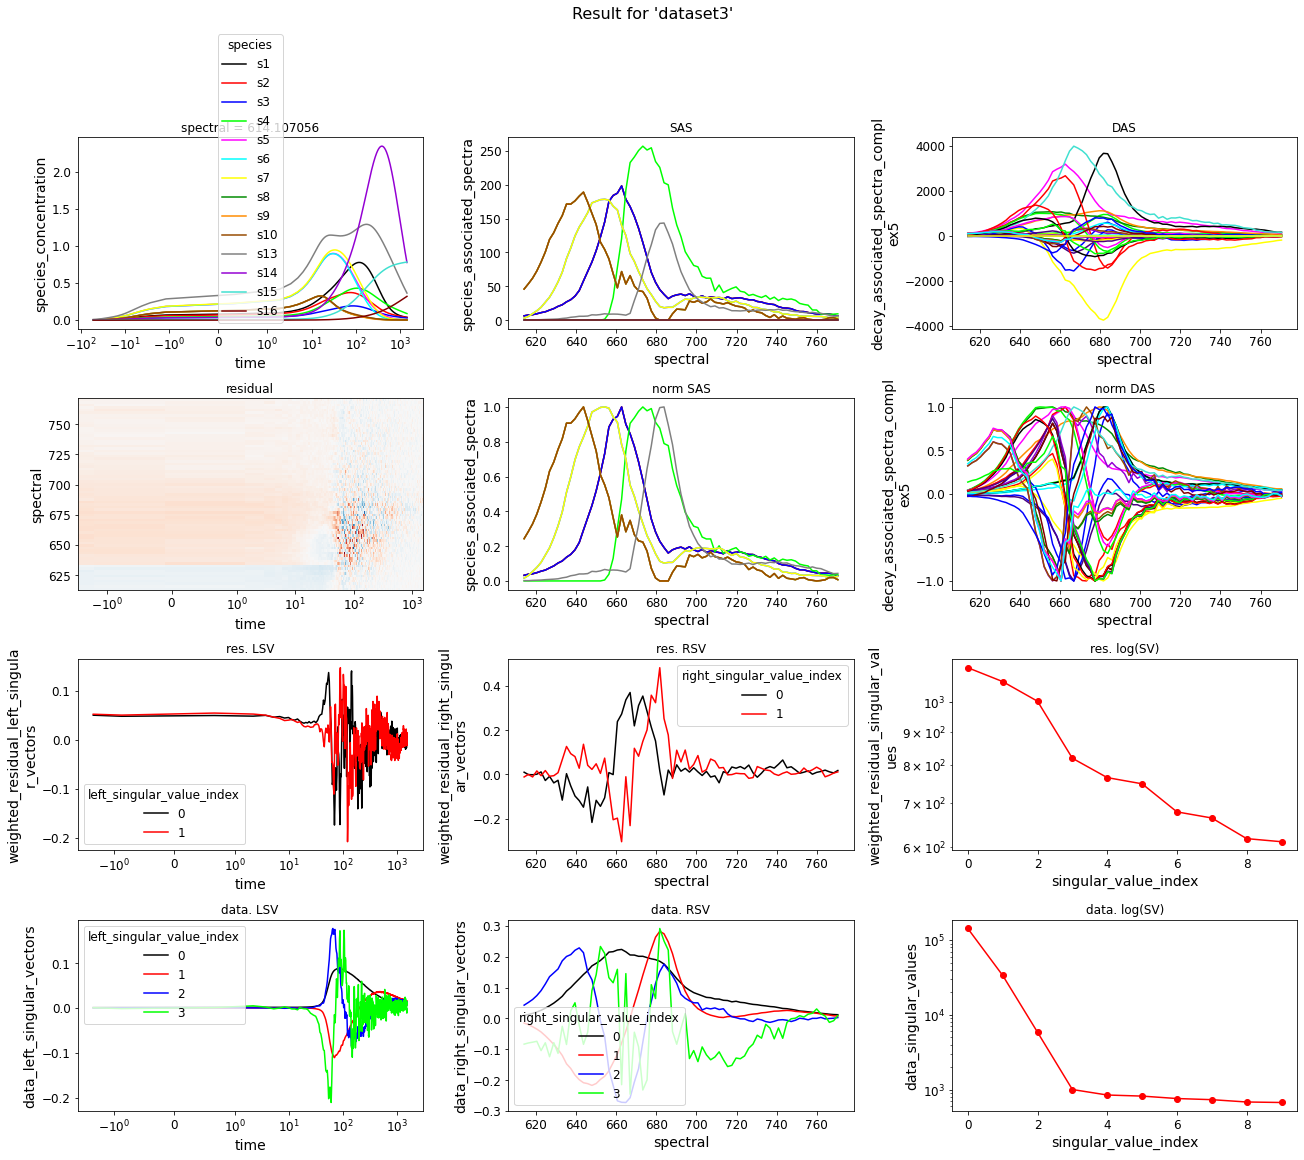

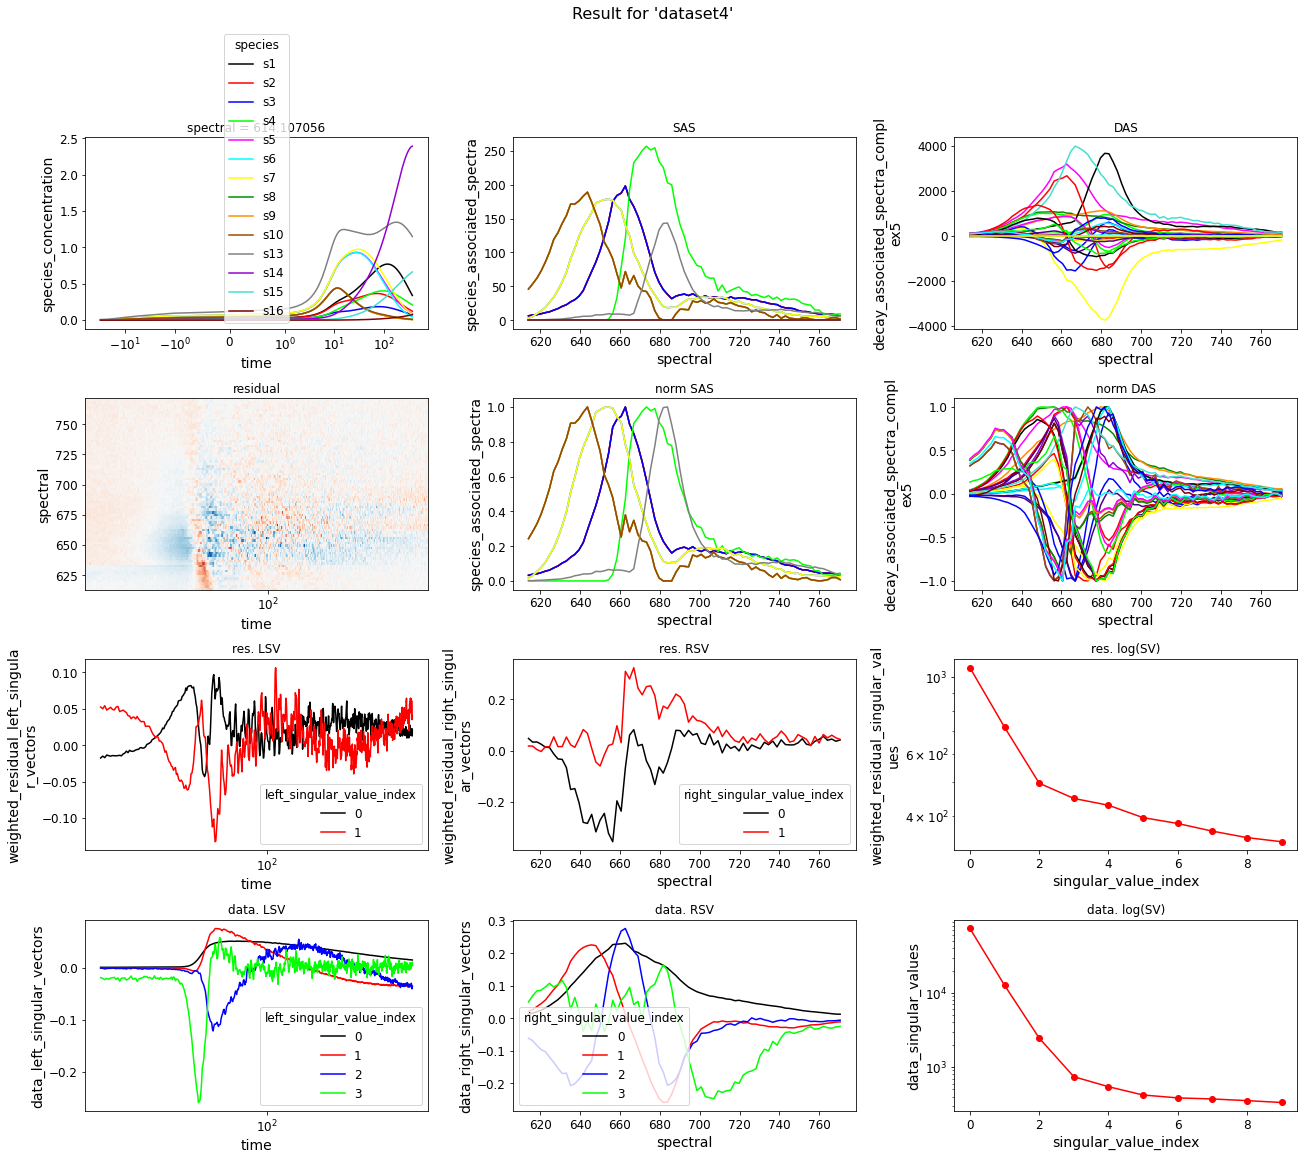

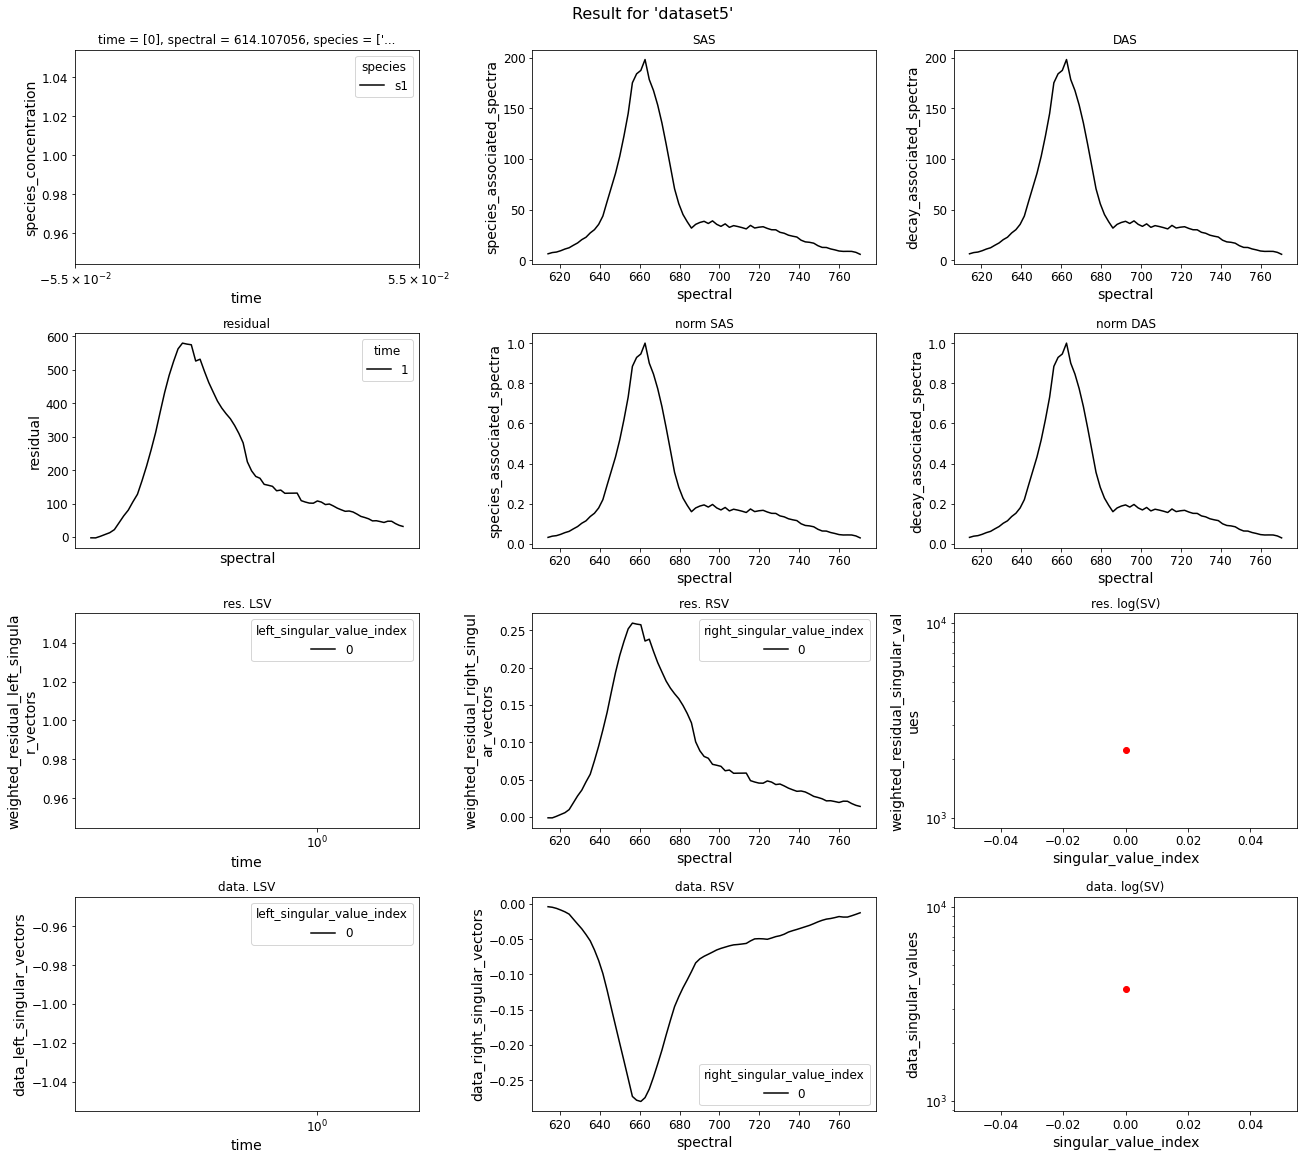

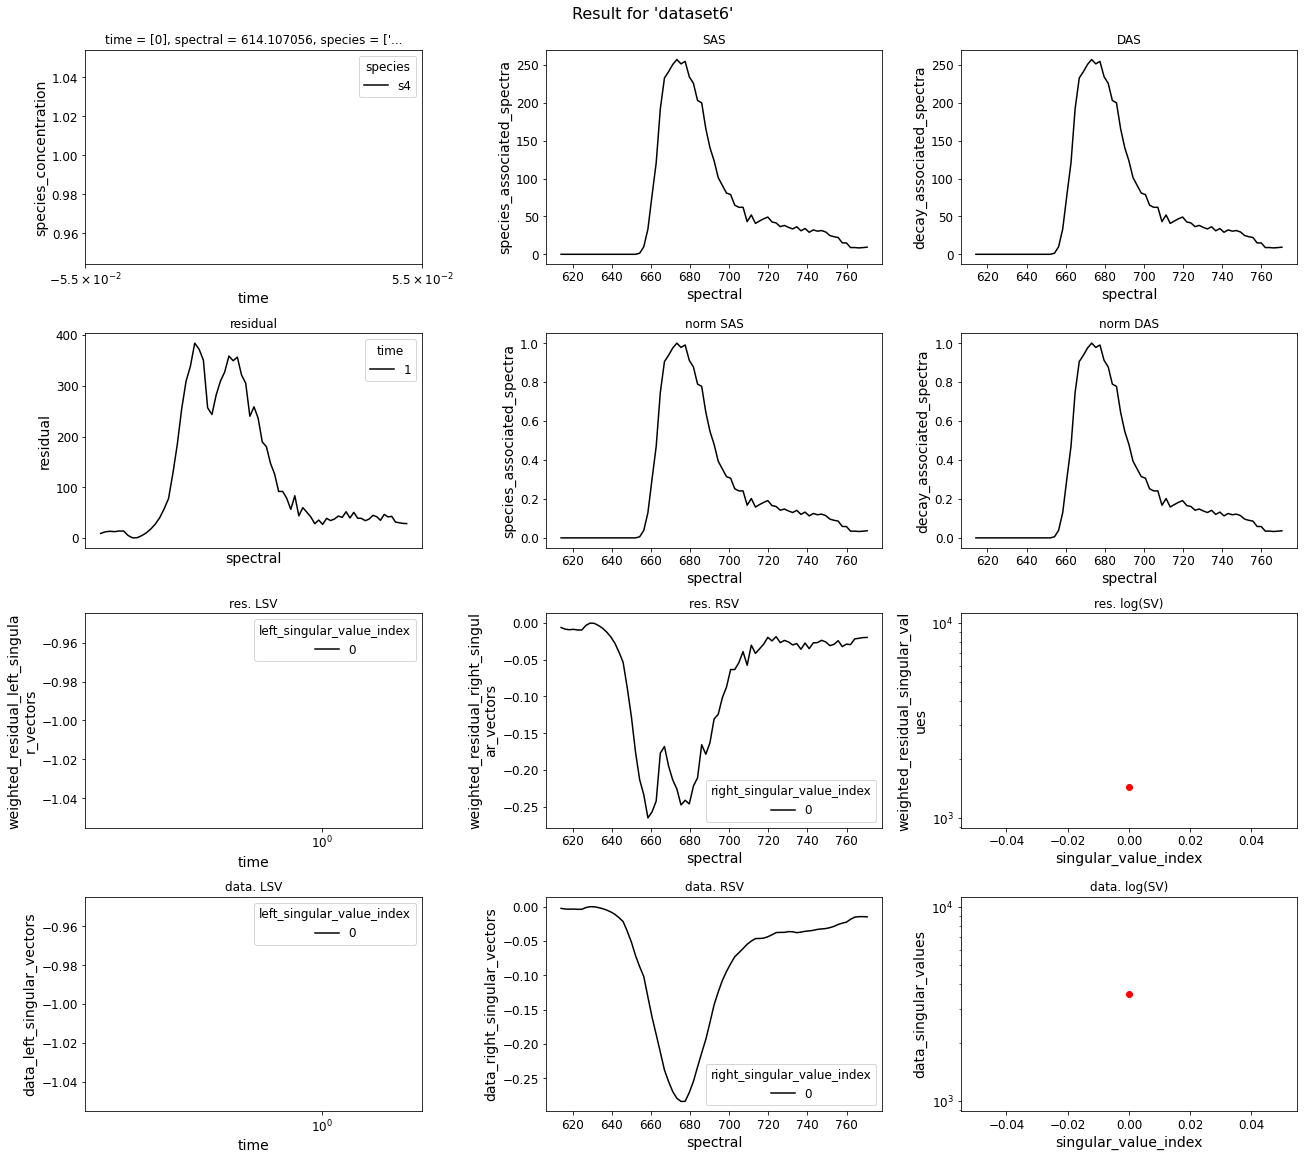

In [32]:
for dataset_name in six_datasets.keys():
    fig = plot_overview(guidance_result.data[dataset_name]);
    fig.suptitle(f'Result for {dataset_name!r}', fontsize=16)

In [33]:
print_md(sequential_result.optimized_parameters)

  * __inputs__:

    | _Label_   |   _Value_ |   _StdErr_ |   _Min_ |   _Max_ | _Vary_   | _Non-Negative_   | _Expr_   |
    |-----------|-----------|------------|---------|---------|----------|------------------|----------|
    | s1        |         0 |          0 |    -inf |     inf | False    | False            | None     |
    | s2        |         1 |          0 |    -inf |     inf | False    | False            | None     |

  * __irf__:

    | _Label_           |      _Value_ |    _StdErr_ |   _Min_ |   _Max_ | _Vary_   | _Non-Negative_   | _Expr_   |
    |-------------------|--------------|-------------|---------|---------|----------|------------------|----------|
    | center1           |    51.2006   | 0           |    -inf |     inf | False    | False            | None     |
    | center2           |    50.7999   | 0           |    -inf |     inf | False    | False            | None     |
    | center3           |    50.8097   | 0           |    -inf |     inf | False    | False            | None     |
    | center4           |    50.6241   | 0           |    -inf |     inf | False    | False            | None     |
    | width1            |     8.1106   | 0           |    -inf |     inf | False    | False            | None     |
    | width2            |    37.0027   | 0           |    -inf |     inf | False    | False            | None     |
    | width3            |     2.9626   | 0           |    -inf |     inf | False    | False            | None     |
    | width4            |    18.3664   | 0           |    -inf |     inf | False    | False            | None     |
    | width5            |     8.2726   | 0           |    -inf |     inf | False    | False            | None     |
    | width6            |    25.1026   | 0           |    -inf |     inf | False    | False            | None     |
    | width7            |     3.38693  | 0           |    -inf |     inf | False    | False            | None     |
    | width8            |    14.6401   | 0           |    -inf |     inf | False    | False            | None     |
    | scale1            |     1        | 0           |    -inf |     inf | False    | False            | None     |
    | scale2            |     0.183932 | 0.000384904 |    -inf |     inf | True     | False            | None     |
    | scale3            |     0.13267  | 0.000716372 |    -inf |     inf | True     | False            | None     |
    | scale4            |     0.251294 | 0.000105041 |    -inf |     inf | True     | False            | None     |
    | scale5            |     0.183123 | 0.000180986 |    -inf |     inf | True     | False            | None     |
    | common_dispcenter |   700        | 0           |    -inf |     inf | False    | False            | None     |
    | data1_disp1       |    -1.64111  | 0           |    -inf |     inf | False    | False            | None     |
    | data1_disp2       |     4.38865  | 0           |    -inf |     inf | False    | False            | None     |
    | data1_disp3       |    -2.19848  | 0           |    -inf |     inf | False    | False            | None     |
    | data1_disp4       |     6.1781   | 0           |    -inf |     inf | False    | False            | None     |
    | common_backsweep  | 13800        | 0           |    -inf |     inf | False    | False            | None     |

  * __rates__:

    | _Label_   |     _Value_ |    _StdErr_ |   _Min_ |   _Max_ | _Vary_   | _Non-Negative_   | _Expr_   |
    |-----------|-------------|-------------|---------|---------|----------|------------------|----------|
    | k1        | 0.0443753   | 0.000244205 |    -inf |     inf | True     | False            | None     |
    | k2        | 0.0155426   | 5.327e-05   |    -inf |     inf | True     | False            | None     |
    | k3        | 0.00567269  | 5.09484e-06 |    -inf |     inf | True     | False            | None     |
    | k4        | 0.000685806 | 2.61558e-07 |    -inf |     inf | True     | False            | None     |

  * __rates2__:

    | _Label_   |     _Value_ |    _StdErr_ |   _Min_ |   _Max_ | _Vary_   | _Non-Negative_   | _Expr_   |
    |-----------|-------------|-------------|---------|---------|----------|------------------|----------|
    | k1        | 0.0473777   | 3.33403e-05 |    -inf |     inf | True     | False            | None     |
    | k2        | 0.0125808   | 5.28736e-06 |    -inf |     inf | True     | False            | None     |
    | k3        | 0.0062888   | 9.33754e-07 |    -inf |     inf | True     | False            | None     |
    | k4        | 0.000966867 | 1.27058e-07 |    -inf |     inf | True     | False            | None     |

  * __rel__:

    | _Label_   |   _Value_ |   _StdErr_ |   _Min_ |   _Max_ | _Vary_   | _Non-Negative_   | _Expr_   |
    |-----------|-----------|------------|---------|---------|----------|------------------|----------|
    | r1        |         1 |          0 |    -inf |     inf | False    | False            | None     |

  * __scale__:

    |   _Label_ |   _Value_ |    _StdErr_ |   _Min_ |   _Max_ | _Vary_   | _Non-Negative_   | _Expr_   |
    |-----------|-----------|-------------|---------|---------|----------|------------------|----------|
    |         1 |  1        | 0           |    -inf |     inf | False    | False            | None     |
    |         2 |  0.224629 | 0.00107985  |    -inf |     inf | True     | False            | None     |
    |         3 |  4.5534   | 0           |    -inf |     inf | False    | False            | None     |
    |         4 |  0.962195 | 0.000823381 |    -inf |     inf | True     | False            | None     |

  * __scalem__:

    |   _Label_ |   _Value_ |   _StdErr_ |   _Min_ |   _Max_ | _Vary_   | _Non-Negative_   | _Expr_   |
    |-----------|-----------|------------|---------|---------|----------|------------------|----------|
    |         1 |         1 |          0 |    -inf |     inf | False    | False            | None     |

